In [0]:
import pandas as pd

DATA_PATH = '/content/gdrive/My Drive/projects/web classification/'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df =pd.read_csv(DATA_PATH + 'train_test2.csv' , header = None)
df.info()

df[2].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 3 columns):
0    2079 non-null object
1    2079 non-null object
2    2079 non-null int64
dtypes: int64(1), object(2)
memory usage: 48.8+ KB


0    1040
1    1039
Name: 2, dtype: int64

In [0]:
def print_plot(index):
    example = df[df.index == index][[1, 2]].values[0]
    if len(example) > 0:
        print(example[0])
        print('Category:', example[1])
print_plot(10)

casino dames new nektan online casino deposit bonuses login register slots casino live casino scratch cards jackpots promotions play sign come join casino dames huge casino games slot games big bonuses deposit incentives join today receive exclusive offer play
Category: 1


In [0]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df[1].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# print(word_index)

In [0]:
X = tokenizer.texts_to_sequences(df[1].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df[2]).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (2079, 250)
Shape of label tensor: (2079, 2)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1871, 250) (1871, 2)
(208, 250) (208, 2)


In [0]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Train on 1683 samples, validate on 188 samples
Epoch 1/5
1683/1683 [==============================] - 31s 18ms/step - loss: 0.5433 - acc: 0.8134 - val_loss: 0.1982 - val_acc: 0.9415
Epoch 2/5
1683/1683 [==============================] - 27s 16ms/step - loss: 0.1325 - acc: 0.9643 - val_loss: 0.0534 - val_acc: 0.9894
Epoch 3/5
1683/1683 [==============================] - 27s 16ms/step - loss: 0.0792 - acc: 0.9822 - val_loss: 0.0894 - val_acc: 0.9840
Epoch 4/5
1683/1683 [==============================] - 27s 16ms/step - loss: 0.0457 - acc: 0.9941 - val_loss: 0.0424 - val_acc: 0.9894
Epoch 5/5
208/208 [==============================] - 1s 4ms/step
Test set
  Loss: 0.059
  Accuracy: 0.976


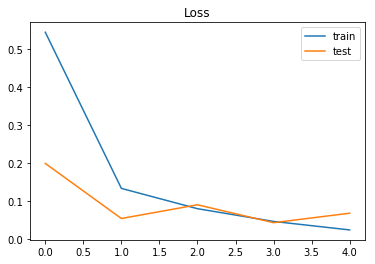

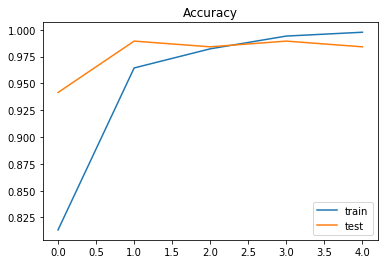

In [0]:
import matplotlib.pylab as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [0]:
import re
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen, HTTPError, Request
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer



# http 403 에러
def get_html(url):
    headers = {
        "User-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36"}

    html = ""
    ret = requests.get(url, headers=headers)

    if ret.status_code == 200:
        html = ret.text

    return html



def link_text(bsObj):
    result = ""

    allText = bsObj.findAll("a")

    for link in allText:
        if 'href' in link.attrs:
            # print(link)
            result += " " + link.get_text()

    return result;



# title 텍스트
def title(bsObj):

    if bsObj.head is None:
        print("no header")
        return ""
    elif bsObj.head.title is None:
        return ""
    else:
        return bsObj.head.title.get_text()


# description 텍스트
def description(bsObj):

    result = ""

    if bsObj.head is None:
        return result

    else:
        for meta in bsObj.head.find_all('meta'):
            if meta.get('name') == "description":
                result += " " + meta.get('content')

        return result


# 키워드
def keyword(bsObj):

    result = ""
    if bsObj.head is None:
        return result

    else:
        for meta in bsObj.head.find_all('meta'):
            if meta.get('name') == "keywords":
                result += " " + str(meta.get('content'))

        return result


# 모든 메타데이터
def meta_data(bsObj):

    result = ""
    metadatas = set()

    if bsObj.head is None:
        return result
    else:
        for meta in bsObj.head.find_all('meta'):
            # print(meta.get('content'))
            metadatas.add(meta.get('content'))

        for data in metadatas:
            result += " " + str(data)

        return result


def page_text(url):

    html = get_html(url)
    bsObj = BeautifulSoup(html, "html.parser")

    title2 = title(bsObj)
    link_text2 = link_text(bsObj)
    keyword2 = keyword(bsObj)
    description2 = description(bsObj)
    meta_data2 = meta_data(bsObj)

    return (title2 + link_text2 + keyword2 + description2)
#     return (title2 + link_text2 + meta_data2)
    
    
import nltk

nltk.download('stopwords')

review = page_text("https://www.mansioncasino.com/")

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

    # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
    review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)
        
#         print('num of words: ', len(clean_review.split()))

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review
  
print(preprocessing(review, True))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
play mansioncasino online casino bonus join home join log promotions casino games roulette blackjack slots videopoker live casino live roulette real money casino online slots online blackjack live blackjack online roulette live roulette paypal casino join terms conditions apply casino sites play play play play play play play play play play play play play play play play play play download app mansioncasino customer support click click join online casino games online blackjack online roulette online slots online craps video poker live casino live roulette live blackjack payment methods paypal casino visa casino mastercard casino neteller casino paysafecard casino visa electron casino maestro casino pay phone bill casino mansion casino uk mansion casino de mansion casino canada mansion casino africa mansion casino new zealand mansion casino canada fr help contact us secur

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/projects/web classification/data_out/lstm_model.h5')

Using TensorFlow backend.
W0804 23:55:16.816247 139942460053376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 23:55:16.896819 139942460053376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 23:55:16.927005 139942460053376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 23:55:16.928957 139942460053376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default inste

In [0]:
import numpy as np

list = ['http://activbedford.com/']

for i in list:
  url = i

  new_page = [preprocessing(page_text(url), True)]
  print(new_page)
  # new_complaint = ['new online casinos new casinos home new casinos new casinos mobby slots larry casino new casinos rizk casino casino casillion tom casino unique casino everum casino casino girl dunder casino cashmio viks casino new casinos casino land kaboo casino lapalingo insta casino sugar casino omni slots top casinos search software netent microgaming nextgen igt novomatic neogames boss media elk studios saucify aristocrat playtech greentube cryptologic leander games ashgaming blueprint gaming yggdrasil electracade isoftbet x gaming ezugi gaming edict bally merkur gaming real time gaming game art play n go evolution quickspin betsoft endorphina amatic wms skillonnet genesis thunderkick nextgen evolution license uk malta curacao costa rica languages english polish turkisch norwegian swedish finnish russian spanish french german currency euro us dollar uk pound south african rand turkish lira russian ruble romanian lei swiss franc bulgarian leva polish zlotys hungarian forints croatian kunas denmark kroner czech korunas swedish kroner norwegian kroner new zealand dollar canadian dollar australian dollar bonus free spins deposit free spins st deposit welcome bonus welcome bonus site info become member contact us us list casino disclaimer mobile home new casinos new casinos mobby slots larry casino new casinos rizk casino casino casillion tom casino unique casino everum casino casino girl dunder casino cashmio viks casino new casinos casino land kaboo casino lapalingo insta casino sugar casino omni slots top casinos search software netent microgaming nextgen igt novomatic neogames boss media elk studios saucify aristocrat playtech greentube cryptologic leander games ashgaming blueprint gaming yggdrasil electracade isoftbet x gaming ezugi gaming edict bally merkur gaming real time gaming game art play n go evolution quickspin betsoft endorphina amatic wms skillonnet genesis thunderkick nextgen evolution license uk malta curacao costa rica languages english polish turkisch norwegian swedish finnish russian spanish french german currency euro us dollar uk pound south african rand turkish lira russian ruble romanian lei swiss franc bulgarian leva polish zlotys hungarian forints croatian kunas denmark kroner czech korunas swedish kroner norwegian kroner new zealand dollar canadian dollar australian dollar bonus free spins deposit free spins st deposit welcome bonus welcome bonus site info become member contact us us list casino disclaimer mobile powered framework read review read review read review read review read review read review visit casino read review visit casino read review visit casino read review visit casino new casinos read review visit casino read review visit casino read review visit casino read review visit casino new casinos read review visit casino read review visit casino read review visit casino read review visit casino netent casinos amatic play n go betsoft microgaming software providers english swedish german norwegian finnish software providers euro uk pound swedish kroner norwegian kroner us dollar currencies uk license malta license curacao license sign new casinos new casinos free spins deposit free spins st deposit welcome bonus welcome bonus search software search language search license search currency become member contact us us list casino disclaimer new casinos new online casino best signup bonus best new casino st deposit bonus review new online casino casino online new welcome bonus new casino best new casinos best online casino new try new online casinos free spins high st deposit bonus read casino players say new online casino bonus offer get']
  seq = tokenizer.texts_to_sequences(new_page)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  labels = [0,1]

  print(pred)

  if labels[np.argmax(pred)] == 1:
    print('gamble')
  else:
    print('normal')
    


['activbedford casinos gambling skip content home us blog let connect use gambling bonus fruitfully december wp activ factors consider selecting good online casino december february wp activ play slot online casinos casino book important source information casino players december wp activ use gambling bonus fruitfully factors consider selecting good online casino casino book important source information casino players blog https www youtube com watch v v ofo tec privacy information terms services let connect sitemap proudly powered wordpress fernando villamor jr']
[[0.6081018  0.39189819]]
normal


In [0]:

# 언어 확인
def lang(url):
    html = get_html(url)
    bsObj = BeautifulSoup(html, "html.parser")
    for html in bsObj.findAll('html'):
        if html.get('lang') is None:
            return False
        elif 'en' in html.get('lang'):
            return True
        else:
            return False
          
import csv

DATA_PATH = '/content/gdrive/My Drive/projects/web classification/'


def write_csv(file_name, output_name):

    page_data = pd.read_csv(DATA_PATH + file_name, header = None, encoding='CP949')
    rows = page_data.shape[0]

    csvFile = open(DATA_PATH + output_name, 'a', newline='')

    try:
        writer = csv.writer(csvFile)


        for i in range(5000,5500):

            url = 'http://' + page_data[0][i]

            try:
              if lang(url) is True:

                new_page = [preprocessing(page_text(url), True)]
                print(new_page)
                # new_complaint = ['new online casinos new casinos home new casinos new casinos mobby slots larry casino new casinos rizk casino casino casillion tom casino unique casino everum casino casino girl dunder casino cashmio viks casino new casinos casino land kaboo casino lapalingo insta casino sugar casino omni slots top casinos search software netent microgaming nextgen igt novomatic neogames boss media elk studios saucify aristocrat playtech greentube cryptologic leander games ashgaming blueprint gaming yggdrasil electracade isoftbet x gaming ezugi gaming edict bally merkur gaming real time gaming game art play n go evolution quickspin betsoft endorphina amatic wms skillonnet genesis thunderkick nextgen evolution license uk malta curacao costa rica languages english polish turkisch norwegian swedish finnish russian spanish french german currency euro us dollar uk pound south african rand turkish lira russian ruble romanian lei swiss franc bulgarian leva polish zlotys hungarian forints croatian kunas denmark kroner czech korunas swedish kroner norwegian kroner new zealand dollar canadian dollar australian dollar bonus free spins deposit free spins st deposit welcome bonus welcome bonus site info become member contact us us list casino disclaimer mobile home new casinos new casinos mobby slots larry casino new casinos rizk casino casino casillion tom casino unique casino everum casino casino girl dunder casino cashmio viks casino new casinos casino land kaboo casino lapalingo insta casino sugar casino omni slots top casinos search software netent microgaming nextgen igt novomatic neogames boss media elk studios saucify aristocrat playtech greentube cryptologic leander games ashgaming blueprint gaming yggdrasil electracade isoftbet x gaming ezugi gaming edict bally merkur gaming real time gaming game art play n go evolution quickspin betsoft endorphina amatic wms skillonnet genesis thunderkick nextgen evolution license uk malta curacao costa rica languages english polish turkisch norwegian swedish finnish russian spanish french german currency euro us dollar uk pound south african rand turkish lira russian ruble romanian lei swiss franc bulgarian leva polish zlotys hungarian forints croatian kunas denmark kroner czech korunas swedish kroner norwegian kroner new zealand dollar canadian dollar australian dollar bonus free spins deposit free spins st deposit welcome bonus welcome bonus site info become member contact us us list casino disclaimer mobile powered framework read review read review read review read review read review read review visit casino read review visit casino read review visit casino read review visit casino new casinos read review visit casino read review visit casino read review visit casino read review visit casino new casinos read review visit casino read review visit casino read review visit casino read review visit casino netent casinos amatic play n go betsoft microgaming software providers english swedish german norwegian finnish software providers euro uk pound swedish kroner norwegian kroner us dollar currencies uk license malta license curacao license sign new casinos new casinos free spins deposit free spins st deposit welcome bonus welcome bonus search software search language search license search currency become member contact us us list casino disclaimer new casinos new online casino best signup bonus best new casino st deposit bonus review new online casino casino online new welcome bonus new casino best new casinos best online casino new try new online casinos free spins high st deposit bonus read casino players say new online casino bonus offer get']
                seq = tokenizer.texts_to_sequences(new_page)
                padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
                pred = model.predict(padded)
                labels = [0,1]

                if labels[np.argmax(pred)] == 1:
                  category = 'gamble'
                else:
                  category = 'X'
                
                writer.writerow([url, category, preprocessing((page_text(url)), remove_stopwords = True)])
                print(category)
                print("page", i+1, " success")
              else:
                continue

            except requests.exceptions.ConnectionError:
                print("page", i+1,"Connection Error")

            except requests.exceptions.SSLError:
                print("page", i+1,"SSL Error")

            except Exception as e:
                print(e)
                print(url)
                # print('에러 인덱스 =', i)


    finally:
        csvFile.close()



In [0]:
#@title 기본 제목 텍스트
write_csv('url/도박3.csv', 'url/LTSM_test.csv')

['yes https tv tv noca yes']
X
page 5002  success
page 5003 Connection Error
page 5004 Connection Error
['soccer picks x predictions try live soccer picks x soccer picks x predictions fulltime halftime double chance asian handicap goals corners aug august august comment sunday august soccer predictions x soccer tips read aug august august comment saturday august soccer predictions x soccer tips read aug august august comment thursday august soccer predictions x soccer tips read jul july july comment wednesday july soccer predictions x soccer tips read jul july july comment tuesday july soccer predictions x soccer tips read jul july july comment monday july soccer predictions x soccer tips read jul july july comment saturday july soccer predictions x soccer tips read jul july july comment friday july soccer predictions x soccer tips read jul july july comment thursday july soccer predictions x soccer tips read jul july july comment wednesday july soccer predictions x soccer tips read ju

E0805 04:08:14.073716 139942460053376 connection.py:378] Certificate did not match expected hostname: tipsmedoss.com.hemsida.eu. Certificate: {'subject': ((('commonName', 'tipsmedoss.com'),),), 'issuer': ((('countryName', 'US'),), (('organizationName', "Let's Encrypt"),), (('commonName', "Let's Encrypt Authority X3"),)), 'version': 3, 'serialNumber': '03723C1BBC9956E4BCDEEB3B3B87936D4C4C', 'notBefore': 'Jun 19 10:08:50 2019 GMT', 'notAfter': 'Sep 17 10:08:50 2019 GMT', 'subjectAltName': (('DNS', 'mail.tipsmedoss.com'), ('DNS', 'tipsmedoss.com'), ('DNS', 'www.tipsmedoss.com')), 'OCSP': ('http://ocsp.int-x3.letsencrypt.org',), 'caIssuers': ('http://cert.int-x3.letsencrypt.org/',)}


page 5018 Connection Error
page 5019 Connection Error
page 5020 Connection Error
['paypal casinos die besten paypal casinos im deutschen web home live casino das richtige casino merkurcasinos mobile paypal casinos zahlungsmethoden paypal und casinos bonis online casinobonus reviews casinospiele slotgames der progressive jackpot roulette im paypal casino spielen baccarat paypal casinos spielen blackjack online paypal casinos spielen sportwetten sportwetten quoten verschieden wetten videoanleitungen casinovideos news menu paypal als zahlungsm glichkeit hier paypal casino online gl cksspiel und klassische musik interessante fakten mehr der wild worlds slot helfen sie gefiederten superhelden mehr der ninja way slot sechs rollen voller kampfkunst mehr neues willkommenspaket im cherrycasino bis oder freispiele mehr ein neuer deal ab sofort gibt es wazdan spiele bei lapalingo mehr paypal casinos options history feedback donate optionen geschichte feedback donate optionen geschichte feedback d

E0805 04:21:27.733801 139942460053376 connection.py:378] Certificate did not match expected hostname: tuquinielateete.com. Certificate: {'subject': ((('commonName', 'www.tuquinielateete.com'),),), 'issuer': ((('countryName', 'US'),), (('organizationName', "Let's Encrypt"),), (('commonName', "Let's Encrypt Authority X3"),)), 'version': 3, 'serialNumber': '038DD0E156A6AF0C609863F03BAD7E4D8265', 'notBefore': 'Jun 27 12:29:26 2019 GMT', 'notAfter': 'Sep 25 12:29:26 2019 GMT', 'subjectAltName': (('DNS', 'www.tuquinielateete.com'),), 'OCSP': ('http://ocsp.int-x3.letsencrypt.org',), 'caIssuers': ('http://cert.int-x3.letsencrypt.org/',)}


page 5142 Connection Error
['cc cc cc cc']
X
page 5146  success
['cc cc cc cc']
X
page 5147  success
['soccer platform soccer predictions soccer platform soccer predictions skip content log home sign become member payment methods paid membership form success free predictions members vip picks today coupons jackpot games sportpesa mega jackpot sportpesa jackpot sportpesa jackpot tanzania betpawa jackpot betway jackpot betin jackpot winning picks ht ft picks correct score archives contact success archive free soccer picks vip picks jackpot games today coupon winning picks ht ft picks correct score become member contact payment method membership form login members pay paid membership form contact terms privacy policy cookies copyright soccerplatform']
X
page 5152  success
['soccer platform soccer predictions soccer platform soccer predictions skip content log home sign become member payment methods paid membership form success free predictions members vip picks today coupons jackpot games

In [0]:
    from keras.models import load_model

    model.save('/content/gdrive/My Drive/projects/web classification/data_out/lstm_model.h5')  # creates a HDF5 file 'my_model.h5'
#     del model  # deletes the existing model

    # returns a compiled model
    # identical to the previous one
#     model = load_model('my_model.h5')